## Is it a bird?

In [15]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: Download images of birds and non-birds

In [16]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [17]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [18]:
urls = search_images('skiing photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/2433353/pexels-photo-2433353.jpeg?cs=srgb&dl=photo-of-person-skiing-on-snowfield-2433353.jpg&fm=jpg'

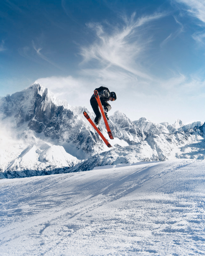

In [19]:
from fastdownload import download_url
dest = 'ski.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

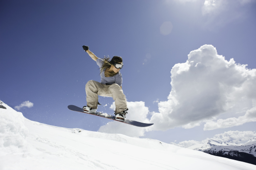

In [20]:
download_url(search_images('snowboarding photos', max_images=1)[0], 'snowboard.jpg', show_progress=False)
Image.open('snowboard.jpg').to_thumb(256,256)

In [21]:
searches = 'skiing','snowboarding'
path = Path('ski_vs_snowboard')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} competition photo'))
    # sleep(10)
    # download_images(dest, urls=search_images(f'{o} equipment photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [22]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

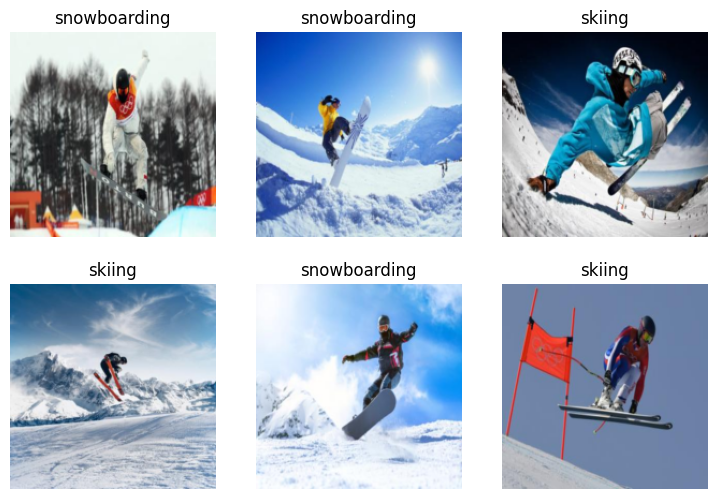

In [23]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

/home/vscode/.local/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,error_rate,time
0,1.331683,0.970120,0.412698,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.943828,0.838559,0.412698,00:06
1,0.765084,0.750940,0.317460,00:06
2,0.609795,0.781098,0.317460,00:06
3,0.497243,0.810251,0.301587,00:06
4,0.421593,0.764075,0.253968,00:06
5,0.347076,0.729488,0.253968,00:06
6,0.295845,0.727629,0.253968,00:06
7,0.257075,0.721260,0.238095,00:06
8,0.224802,0.730087,0.269841,00:07
9,0.198314,0.717276,0.269841,00:06


## Step 3: Use our model (and build your own!)

In [25]:
is_ski,_,probs = learn.predict(PILImage.create('ski.jpg'))
print(f"This is a: {is_ski}.")
print(f"Probability it's a skiier: {probs[0]:.4f}")

This is a: skiing.
Probability it's a skiier: 0.9999
